In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

import torch
from torch.nn.functional import mse_loss

import utils

In [2]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime
from scipy import stats
from scipy.stats import boxcox
import statsmodels.tsa as smt

In [3]:
df = pd.read_csv("./krwvnd.csv")
df.head()

,Date,Close
0,02/01/2004 23:58:00,"12,6613773"
1,05/01/2004 23:58:00,"12,5970768"
2,06/01/2004 23:58:00,"12,724485"
3,07/01/2004 23:58:00,"12,622449"
4,08/01/2004 23:58:00,"12,6659988"


In [4]:
df["Close"] = df.Close.map(lambda x: np.float32(x.replace(",", ".")))

In [5]:
df["Date"] = df.Date.map(lambda x: pd.to_datetime(x, dayfirst=True).date())

In [6]:
df = df.set_index("Date")
df.head()

,Close
Date,
2004-01-02,12.661377
2004-01-05,12.597076
2004-01-06,12.724485
2004-01-07,12.622449
2004-01-08,12.665998


<Axes: xlabel='Date'>

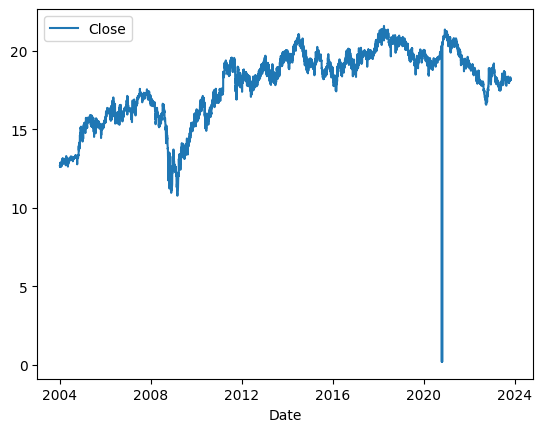

In [7]:
df.plot()

In [8]:
df[df["Close"] < 5] = np.NaN
df.values

array([[12.661377],
       [12.597076],
       [12.724485],
       ...,
       [18.123247],
       [18.211071],
       [18.17288 ]], dtype=float32)

In [9]:
df = df.interpolate()

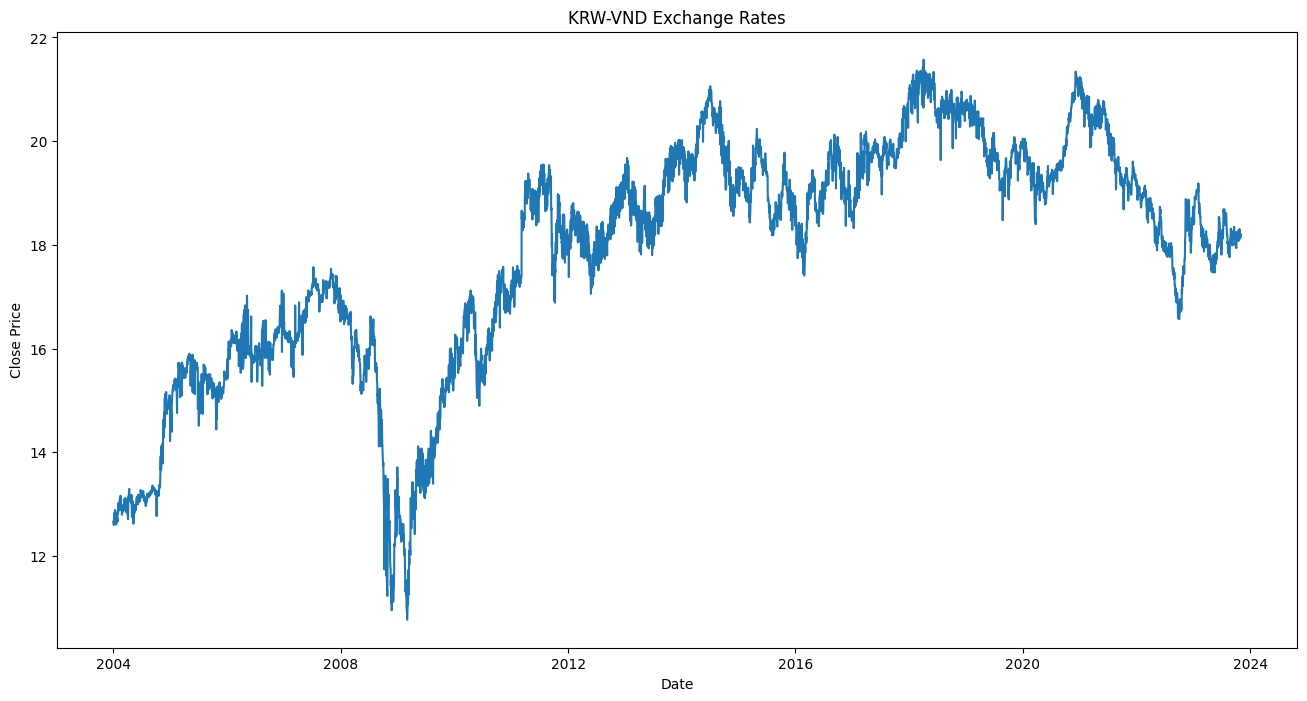

In [10]:
plt.figure(figsize=(16,8))
plt.plot(df)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("KRW-VND Exchange Rates")
plt.show()

In [11]:
df.to_csv("./preprocessed-data/krwvnd.csv")

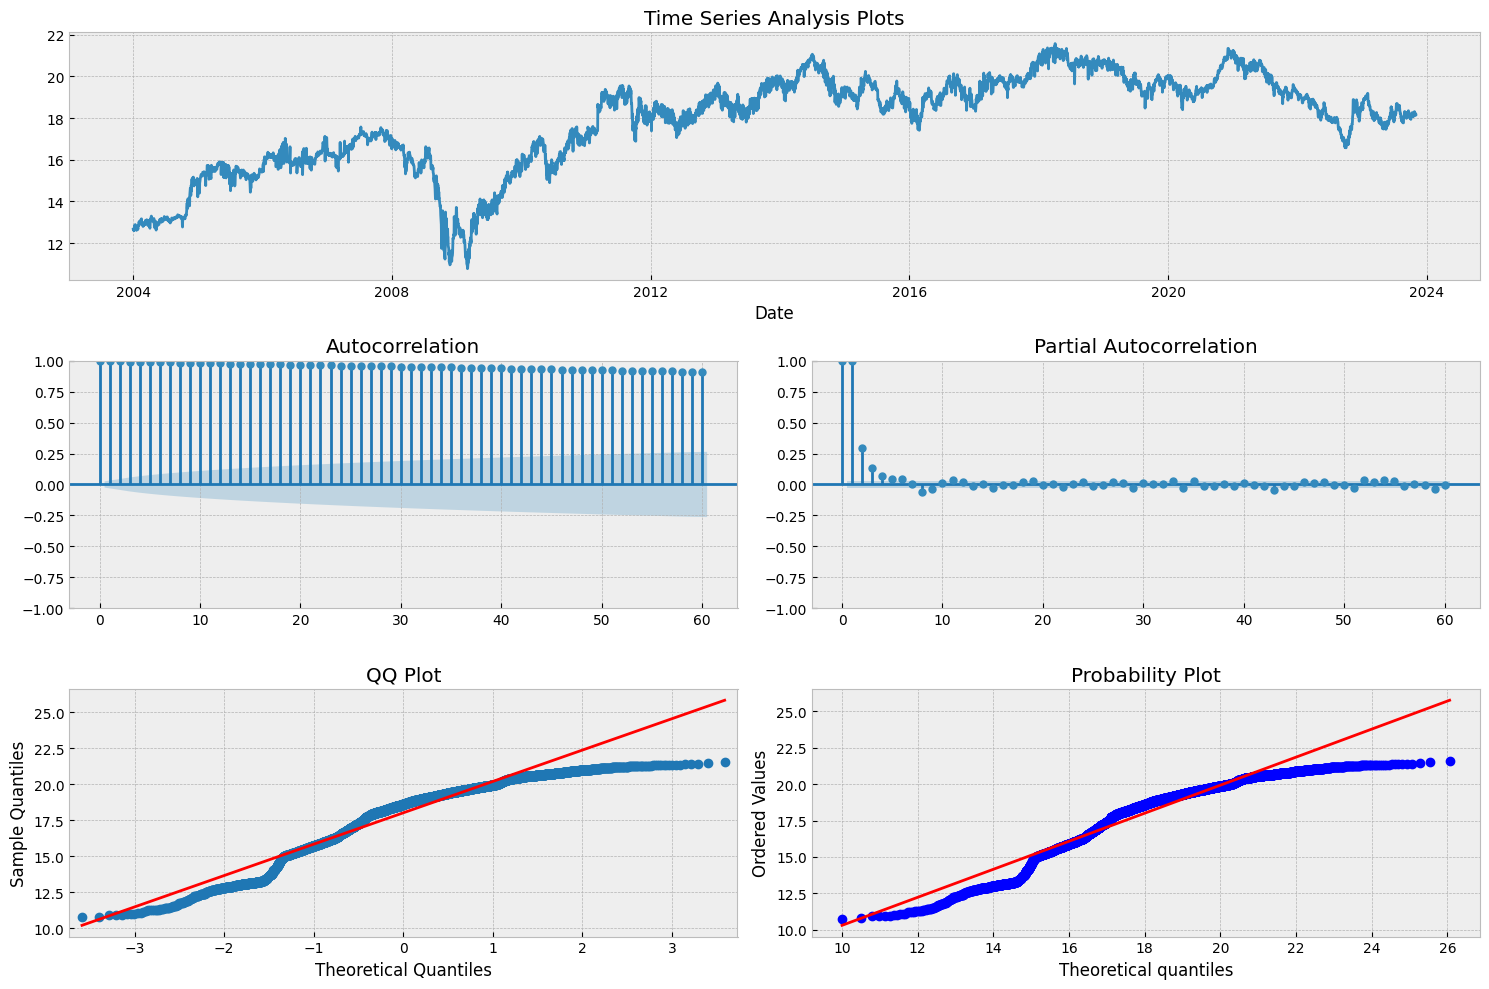

In [13]:
raw_data = utils.tsplot(df['Close'], lags=60)

In [14]:
#1st diffrence
diff_df = df.diff(periods=1).iloc[1:]

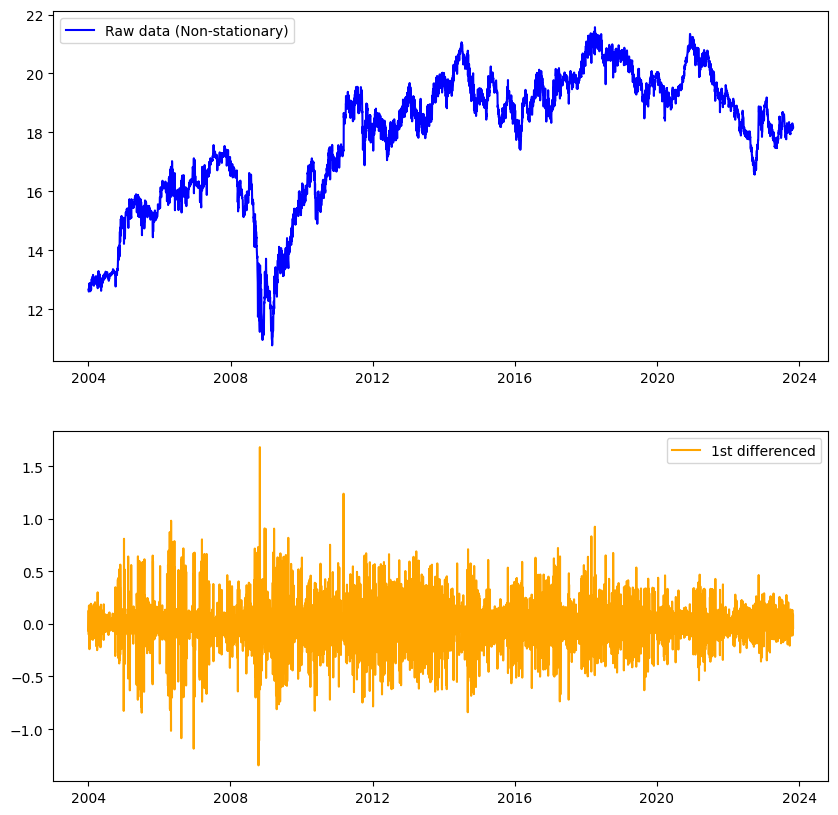

In [15]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(211)
ax1.plot(df, color="blue")
ax1.legend(['Raw data (Non-stationary)'])

ax2 =plt.subplot(212)
ax2.plot(diff_df, color="orange")
ax2.legend(['1st differenced'])

In [16]:
# ADF test

adf_test = adfuller(diff_df)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])

ADF Statistic: -19.866048
Critical Values @ 0.05: -2.86
p-value: 0.00000000000000000000


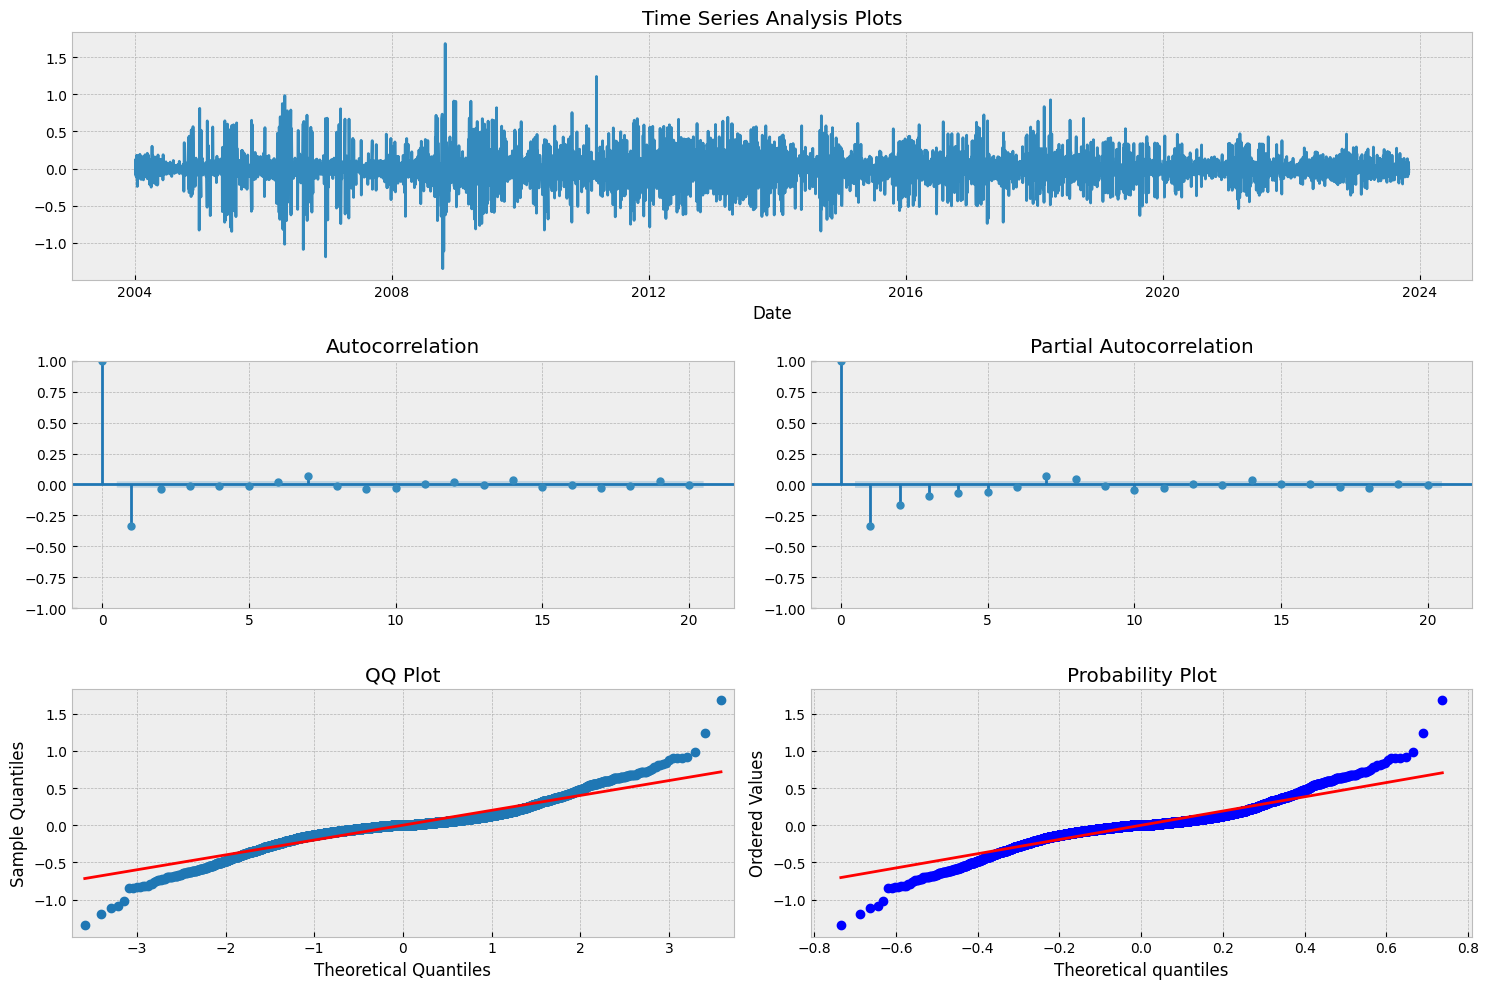

In [17]:
diff_plot= utils.tsplot(diff_df["Close"], lags=20)

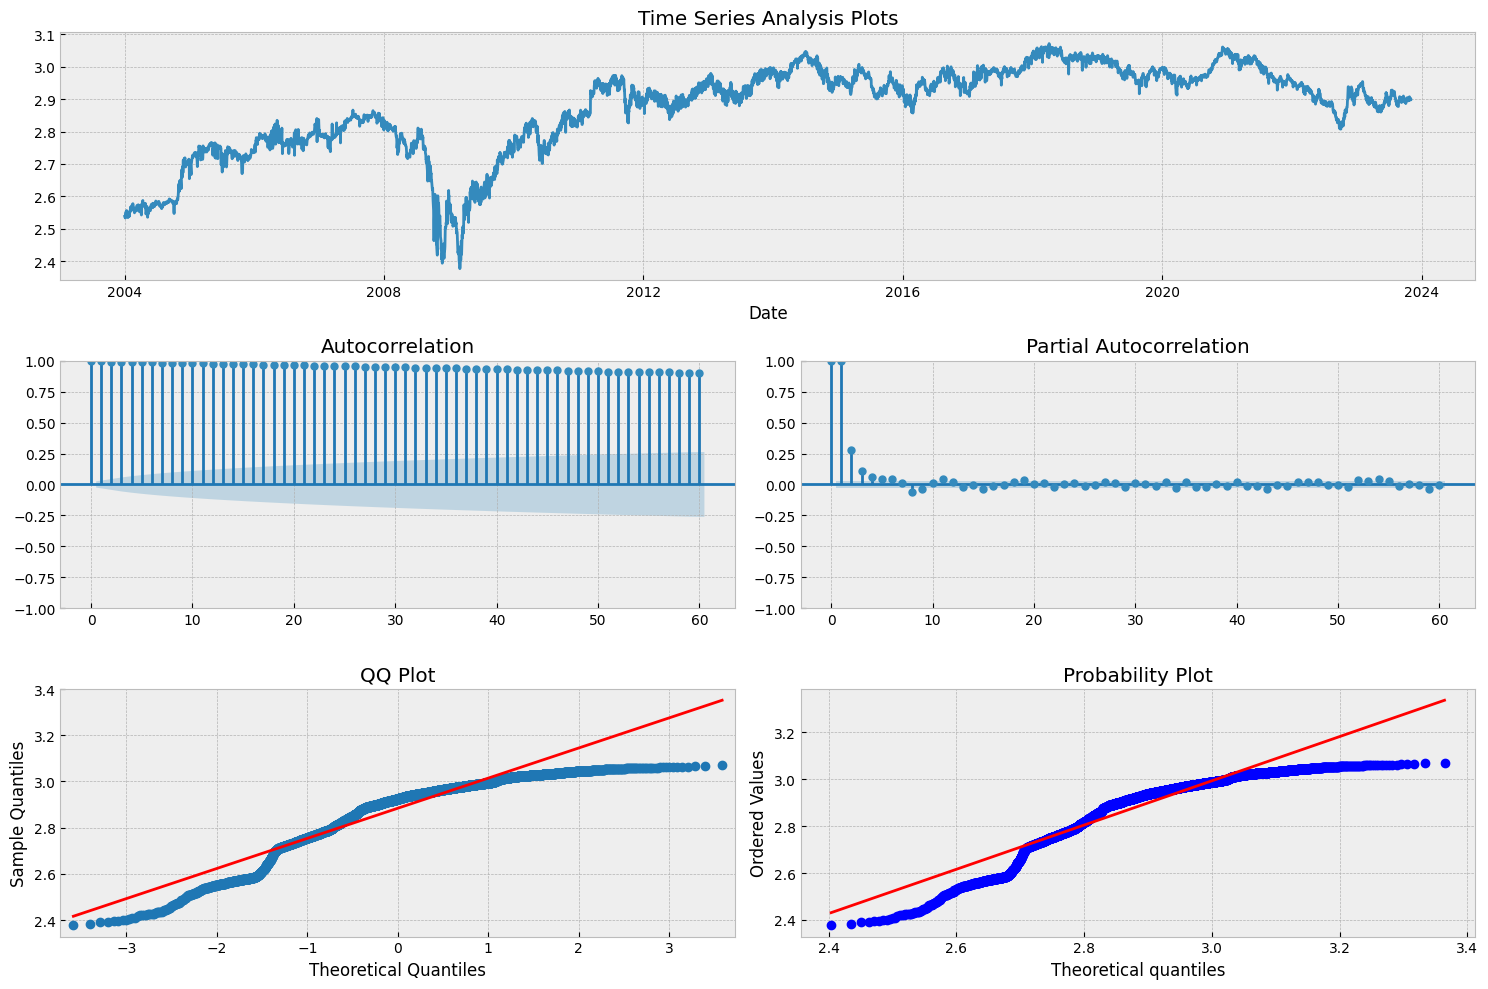

In [18]:
df_log = df.copy()
df_log["Close"] = np.log(df["Close"])
utils.tsplot(df_log["Close"], lags=60)

In [19]:
model = pm.auto_arima(df, d=2,
                      start_p=0, start_q=0, max_order=10, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3591.677, Time=0.29 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=772.451, Time=0.47 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=2.12 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-461.890, Time=0.31 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-1133.580, Time=0.41 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-1531.288, Time=0.49 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=-1869.705, Time=1.23 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=9.50 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=5.62 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-1867.705, Time=1.29 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 21.738 seconds


In [20]:
# create model
model = sm.tsa.arima.ARIMA(df, order=(5,2,0))
results = model.fit()

print(results.summary())

/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5979
Model:                 ARIMA(5, 2, 0)   Log Likelihood                 940.852
Date:                Mon, 04 Dec 2023   AIC                          -1869.705
Time:                        23:05:37   BIC                          -1829.531
Sample:                             0   HQIC                         -1855.751
                               - 5979                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1627      0.008   -138.581      0.000      -1.179      -1.146
ar.L2         -1.0400      0.012    -87.566      0.000      -1.063      -1.017
ar.L3         -0.7984      0.014    -58.981      0.0

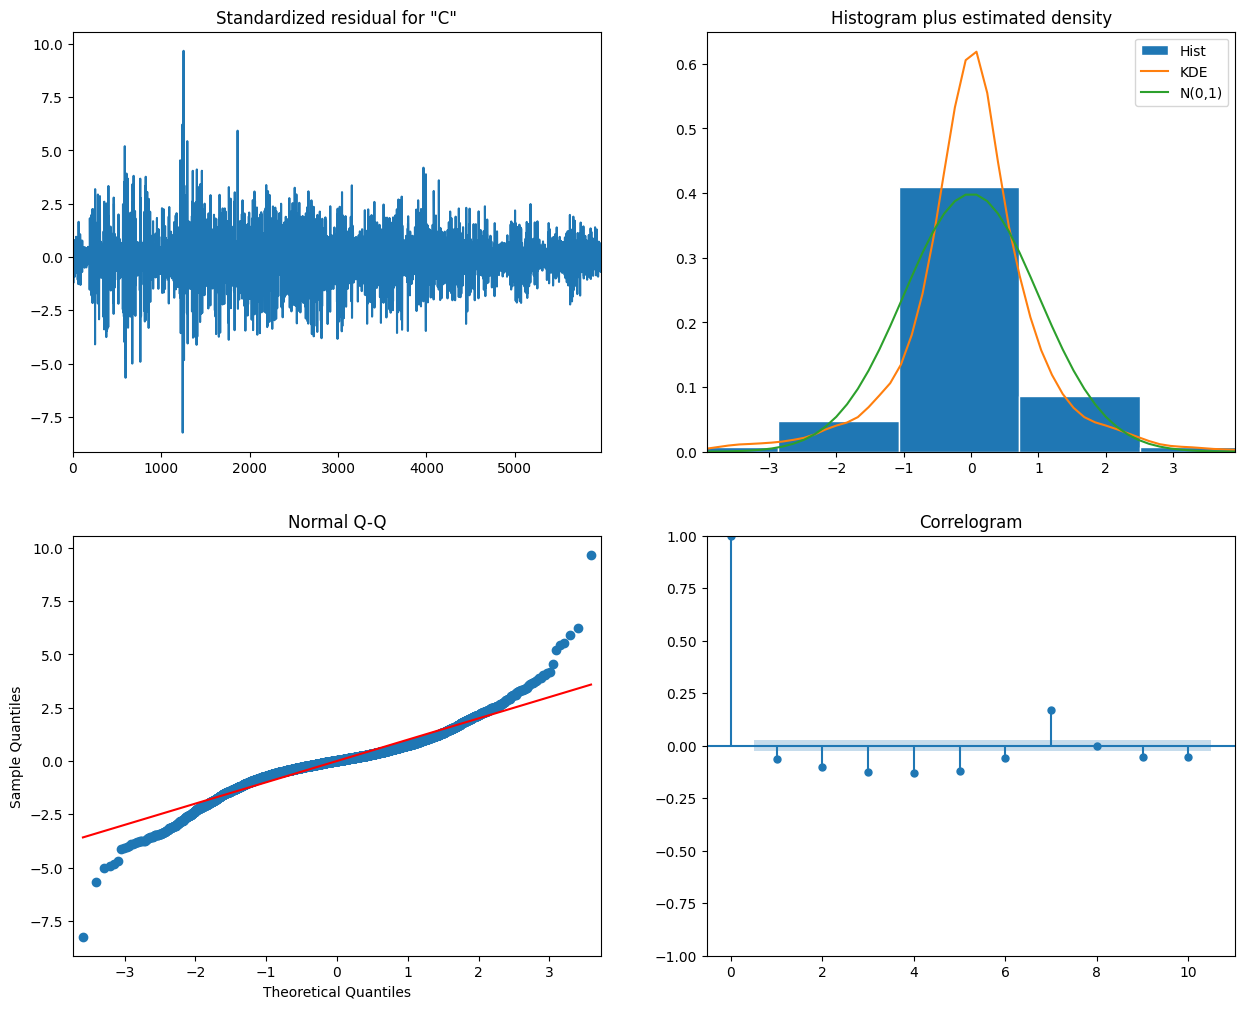

In [21]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

In [22]:
prediction = results.get_forecast(30).predicted_mean.values
prediction

/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


array([18.17695516, 18.17271653, 18.18949913, 18.20083846, 18.21121761,
       18.2059169 , 18.21534407, 18.22257166, 18.23133177, 18.23712421,
       18.24265037, 18.24801321, 18.25594221, 18.26243456, 18.26889408,
       18.27498385, 18.28140419, 18.28798533, 18.2946859 , 18.30101422,
       18.30743989, 18.31388373, 18.32040316, 18.3269013 , 18.33336865,
       18.33980134, 18.34628022, 18.35275918, 18.35923851, 18.36570551])

In [23]:
test_df = pd.read_csv("./krwvnd-test.csv")
test_df["Close"] = test_df.Close.map(lambda x: np.float32(x.replace(",", ".")))
test_df["Date"] = test_df.Date.map(lambda x: pd.to_datetime(x, dayfirst=True).date())
test_df = test_df.set_index("Date")
test_df.head()

,Close
Date,
2023-11-01,18.232344
2023-11-02,18.419567
2023-11-03,18.743101
2023-11-04,18.740891
2023-11-05,18.740891


In [24]:
ground_truth = test_df["Close"].values
ground_truth

array([18.232344, 18.419567, 18.743101, 18.74089 , 18.74089 , 18.739798,
       18.640205, 18.633884, 18.509521, 18.425657, 18.452925, 18.452925,
       18.477781, 18.677027, 18.622482, 18.788408, 18.717506, 18.715784,
       18.715784, 18.764841, 18.624245, 18.666742, 18.397434, 18.57854 ,
       18.581621, 18.581621, 18.581448, 18.643427, 18.812601, 18.695301],
      dtype=float32)

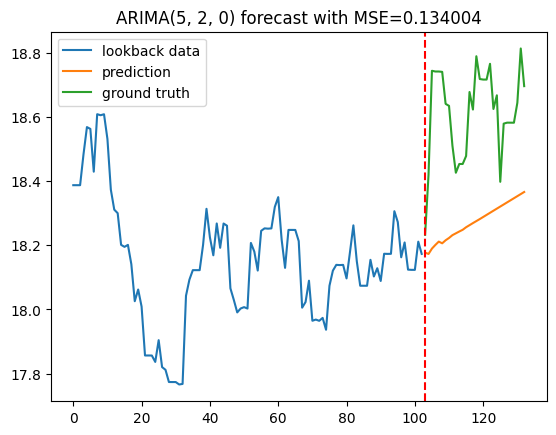

In [27]:
mse = mse_loss(torch.Tensor(prediction), torch.Tensor(ground_truth))
denormalized_data = df[-96-7:]["Close"].to_numpy()
num_lookback = denormalized_data.shape[0]

plt.plot(denormalized_data, label="lookback data")
plt.plot(np.concatenate([np.ones(num_lookback) * np.nan, prediction]), label='prediction')
plt.plot(np.concatenate([np.ones(num_lookback) * np.nan, ground_truth]), label='ground truth')
plt.title(f"ARIMA(5, 2, 0) forecast with MSE={mse:.6f}")
plt.axvline(x=denormalized_data.shape[0], c='r', linestyle='--')
plt.legend()
plt.show()

In [41]:
mse_loss(torch.Tensor(prediction), torch.Tensor(ground_truth))

tensor(0.2194)

Optimal Lambda: 4.181402403138615


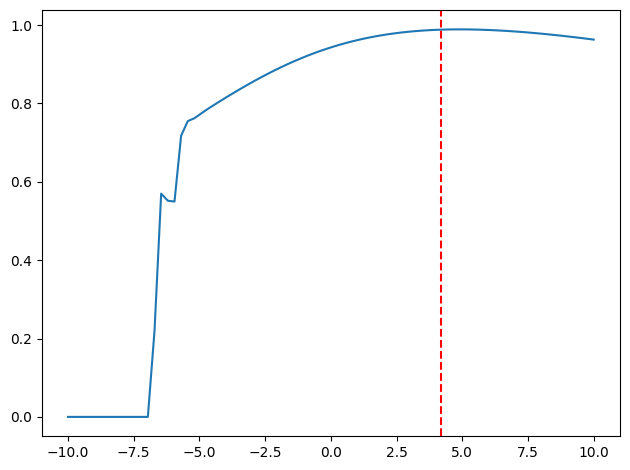

In [20]:
df_boxcox = df.copy()

# Parameter estimation of Box-Cox transformation
#Select the lambda (l_opt) with the highest normality by changing the lambda in a specific range (x) of the normal distribution
x, y = sp.stats.boxcox_normplot(df_boxcox["Close"], la=-10, lb=10) #Normalization Range (-6 ~ 6)

#Returns y and x values converted to normal distribution
y_transfer, l_opt = sp.stats.boxcox(df_boxcox["Close"])

print('Optimal Lambda:', l_opt)

plt.plot(x,y)
plt.axvline(x=l_opt, color='r', ls='--')
plt.tight_layout()
plt.show()

In [21]:
df_boxcox['Close'] = boxcox(df['Close'],lmbda=l_opt)
df_boxcox.head()

,Close
Date,
2004-01-02,9740.552734
2004-01-05,9535.371094
2004-01-06,9945.180664
2004-01-07,9615.937500
2004-01-08,9755.428711


In [22]:
#1st differencing with Box-Cox
diff_df_boxcox = df_boxcox.diff(periods=1).iloc[1:]

#2nd differencing with Box-Cox
diff_2_df_boxcox = df_boxcox.diff(periods=2).iloc[2:]

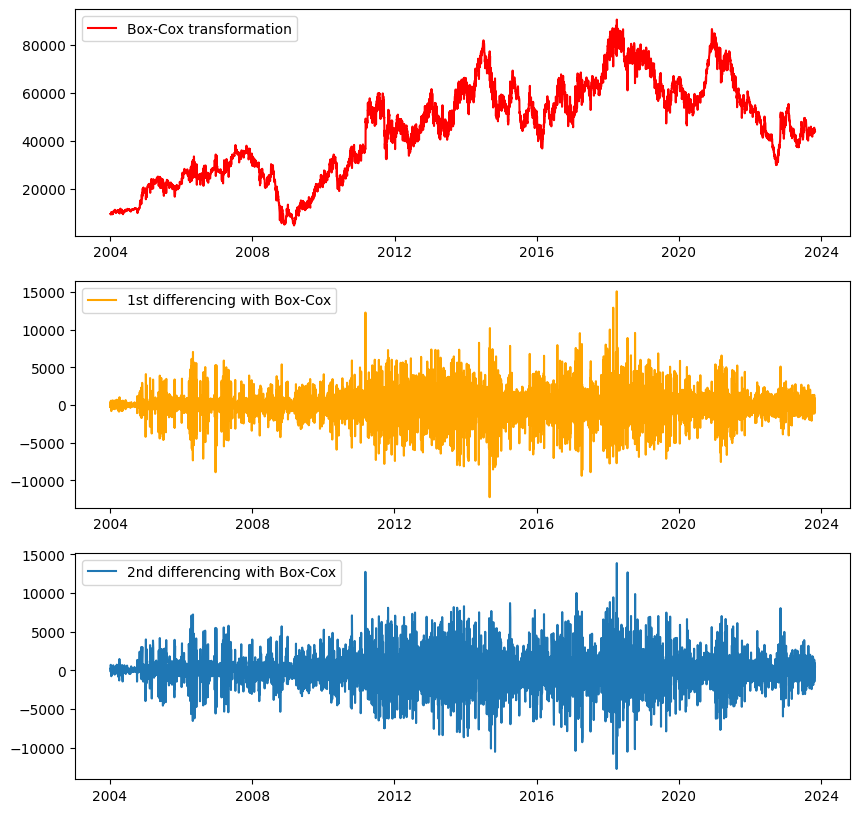

In [23]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(311)
ax1.plot(df_boxcox, color='red')
ax1.legend(['Box-Cox transformation'])


ax2 = plt.subplot(312)
ax2.plot(diff_df_boxcox, color='orange')
ax2.legend(['1st differencing with Box-Cox'])

ax3 =plt.subplot(313)
ax3.plot(diff_2_df_boxcox)
ax3.legend(['2nd differencing with Box-Cox'])

In [24]:
# ADF test

adf_test = adfuller(diff_df_boxcox)
adf_test_ = adfuller(diff_2_df_boxcox)

print('---1st differencing with Box-Cox---')
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])


print('\n---2nd differencing with Box-Cox---')
print('ADF Statistic: %f' % adf_test_[0])
print('Critical Values @ 0.05: %.2f' % adf_test_[4]['5%'])
print('p-value: %20.20f' % adf_test_[1])

---1st differencing with Box-Cox---
ADF Statistic: -14.306467
Critical Values @ 0.05: -2.86
p-value: 0.00000000000000000000

---2nd differencing with Box-Cox---
ADF Statistic: -13.797639
Critical Values @ 0.05: -2.86
p-value: 0.00000000000000000000


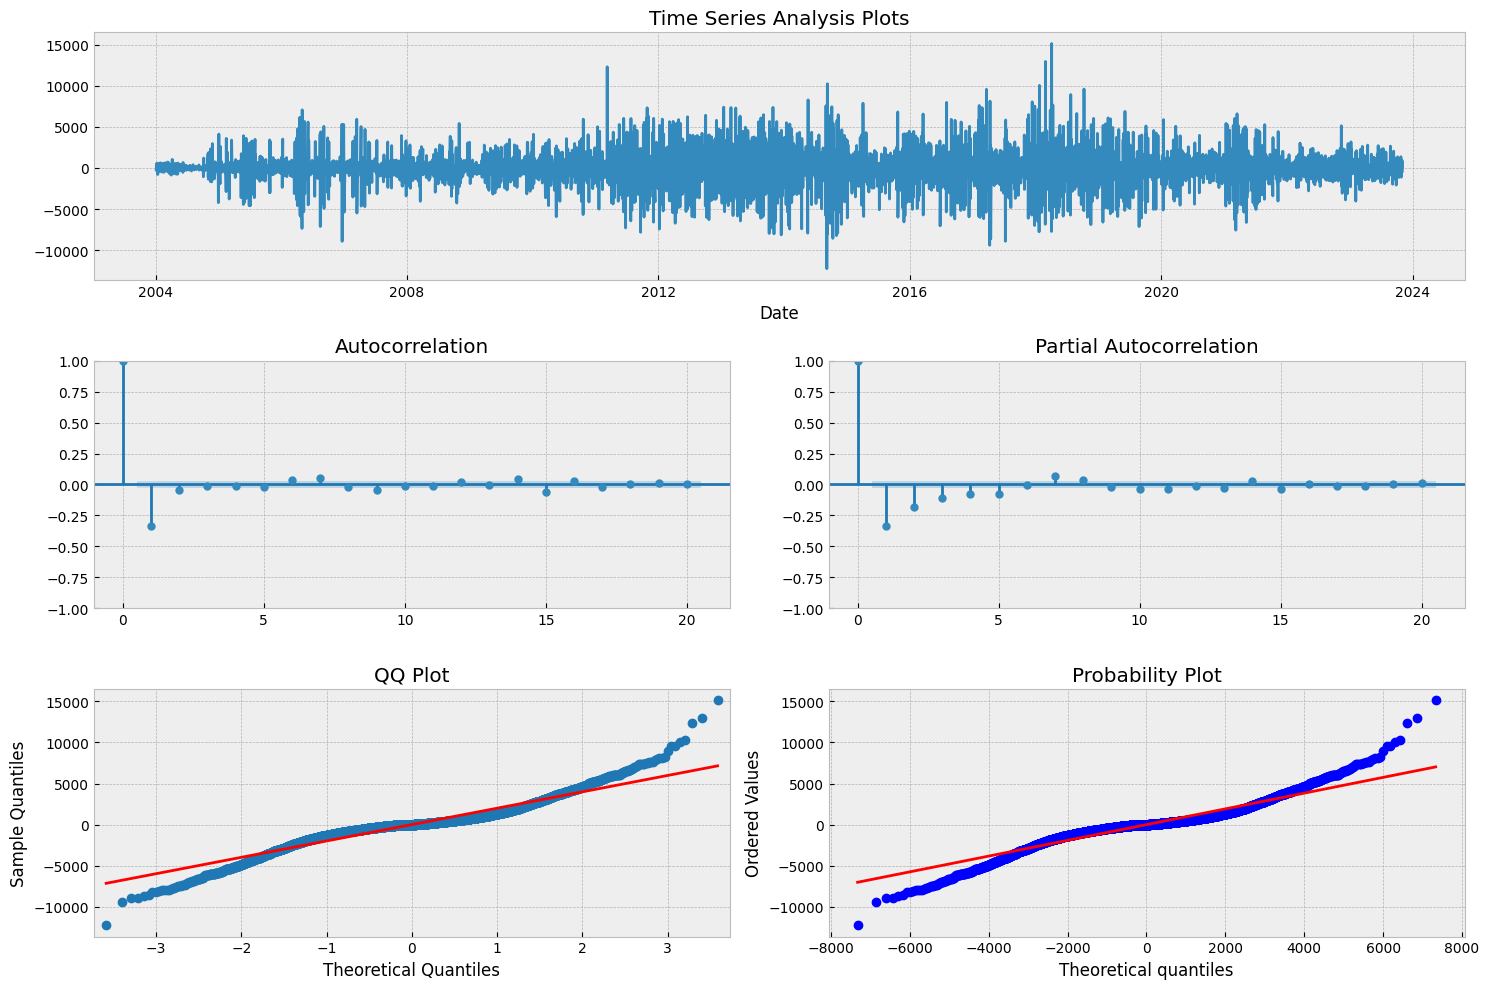

In [25]:
utils.tsplot(diff_df_boxcox["Close"], lags=20)

In [26]:
# The combination is for ARIMA order.

model = pm.auto_arima(df_boxcox, d=1,
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=107785.370, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=107058.474, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=106780.289, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=107783.420, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=106752.753, Time=0.84 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=106754.753, Time=1.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=106754.706, Time=1.85 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=106753.475, Time=0.68 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=106864.868, Time=0.54 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=106756.993, Time=1.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=106750.792, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=106778.447, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=107056.587, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=106752.789, Time=0.65 sec
 ARIM

/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kurone/anaconda3/envs/tsa/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5979
Model:                 ARIMA(4, 1, 1)   Log Likelihood              -53368.085
Date:                Sat, 02 Dec 2023   AIC                         106748.171
Time:                        21:04:08   BIC                         106788.346
Sample:                             0   HQIC                        106762.125
                               - 5979                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0581      0.094     -0.619      0.536      -0.242       0.126
ar.L2         -0.0865      0.041     -2.104      0.035      -0.167      -0.006
ar.L3         -0.0607      0.025     -2.422      0.0

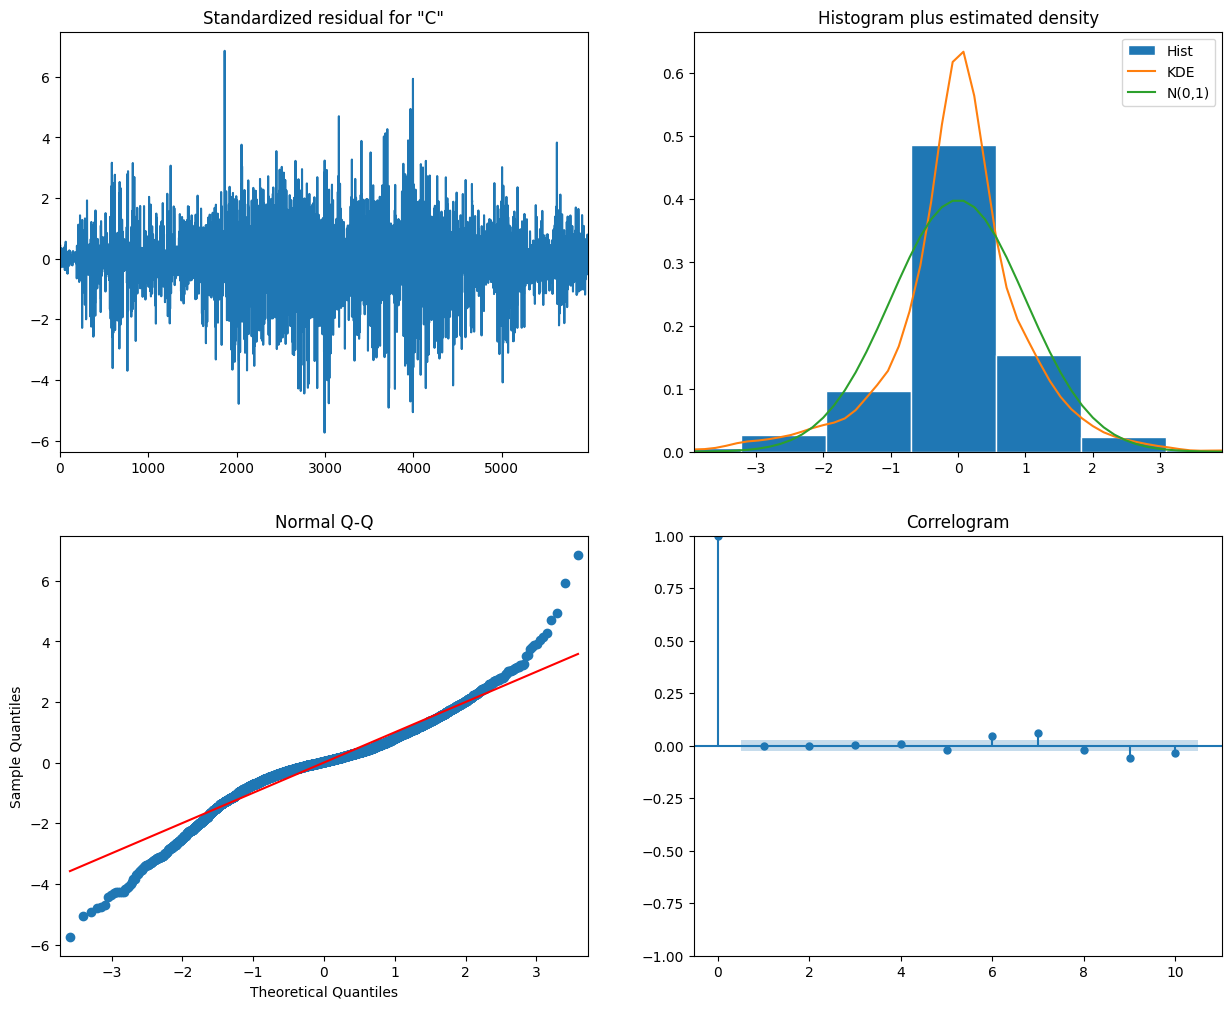

In [27]:
# create model
model = sm.tsa.arima.ARIMA(df_boxcox, order= (4,1,1))
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(15,12))
plt.show()

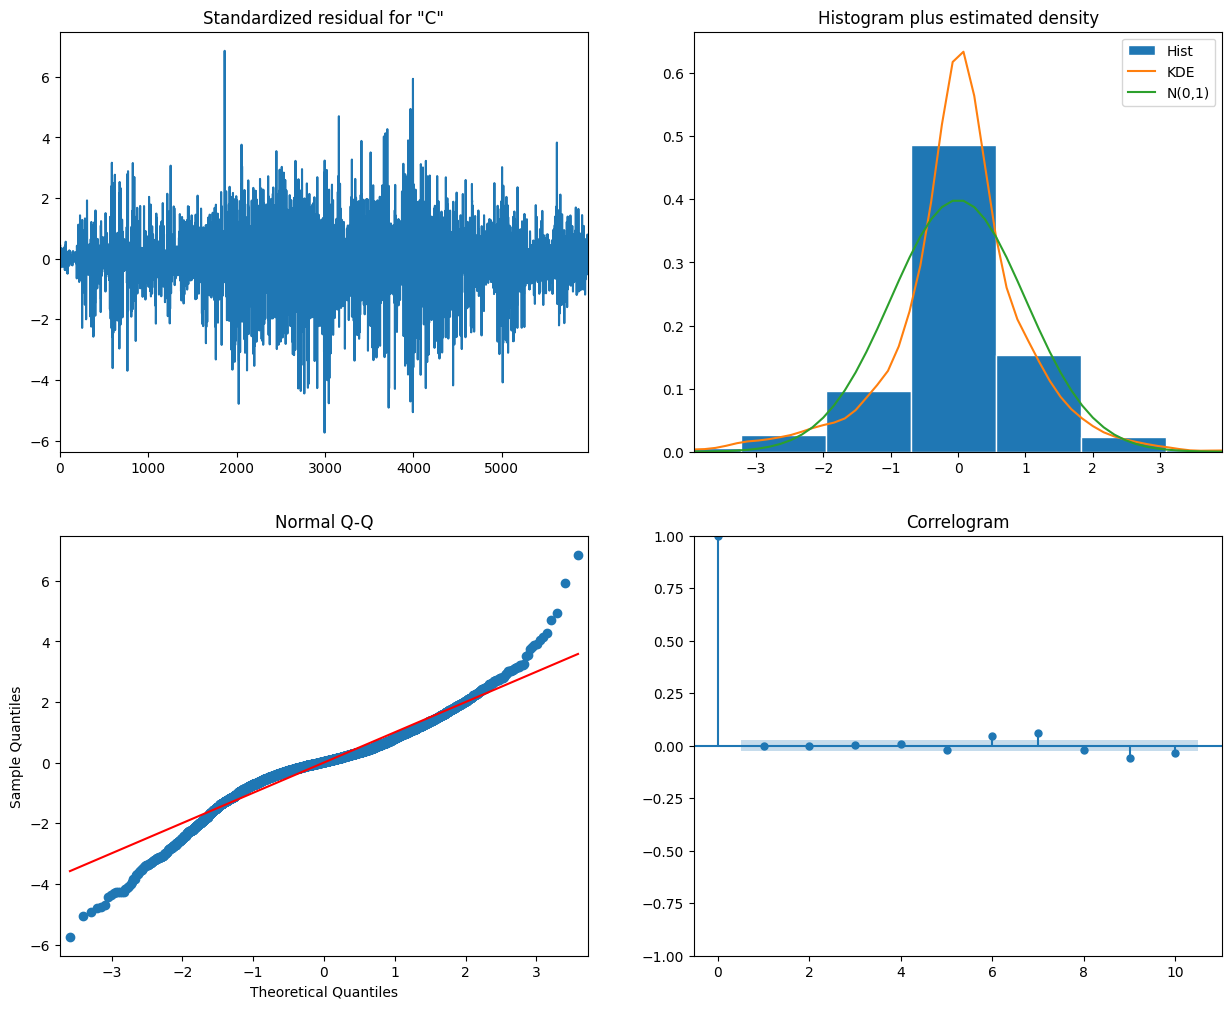

In [28]:
results.plot_diagnostics(figsize=(15,12))
plt.show()